In [1]:
import zipfile

with zipfile.ZipFile('/content/solder-joint-dataset-main.zip', 'r') as zip_ref:
    zip_ref.extractall()

Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74        18
           1       0.57      0.67      0.62        30
           2       0.97      0.98      0.98       547
           3       0.62      0.43      0.51        23
           4       0.85      0.75      0.80        60

    accuracy                           0.92       678
   macro avg       0.74      0.72      0.73       678
weighted avg       0.92      0.92      0.92       678



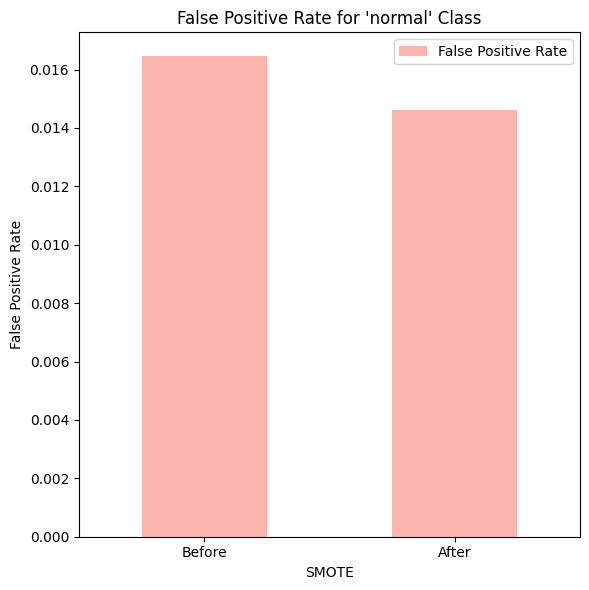

In [11]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import match_template
from imblearn.over_sampling import SMOTE

# ------------------ Image pre processing ------------------

from skimage import exposure, filters
from skimage.restoration import denoise_bilateral
import numpy as np

def preprocess_image(image, img_size=(64, 64)):
    # Resize and scale to [0, 1]
    image = resize(image, img_size, anti_aliasing=True)

    # Convert grayscale to RGB
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[2] == 4:  # Remove alpha channel if present
        image = image[:, :, :3]

    # Optional: Apply histogram equalization (on each channel)
    for i in range(3):
        image[:, :, i] = exposure.equalize_adapthist(image[:, :, i])

    # Optional: Denoising
    #image = denoise_bilateral(image, multichannel=True)

    from skimage.restoration import denoise_bilateral
    image = denoise_bilateral(image, channel_axis=-1)  # -1 means last axis = color channels


    # Optional: Slight sharpening using unsharp mask (not too aggressive!)
    for i in range(3):
        image[:, :, i] = filters.unsharp_mask(image[:, :, i], radius=1, amount=1)

    return image

# ------------------ Custom Feature Extraction Functions ------------------


def highlighted_pixel_percentage(image, threshold=0.8):
    highlighted = (image > threshold).astype(int)
    total_pixels = image.shape[0] * image.shape[1]
    percentages = np.sum(highlighted, axis=(0, 1)) / total_pixels
    return percentages  # [R%, G%, B%]

def grey_values_of_highlighted(image, threshold=0.8):
    gray_img = rgb2gray(image)
    highlighted_mask = np.any(image > threshold, axis=2)
    highlighted_gray_values = gray_img[highlighted_mask]
    if highlighted_gray_values.size == 0:
        return [0, 0]
    return [np.mean(highlighted_gray_values), np.std(highlighted_gray_values)]

def template_matching_features(image, template):
    gray_img = rgb2gray(image)
    template_gray = rgb2gray(template)
    if template_gray.shape[0] > gray_img.shape[0] or template_gray.shape[1] > gray_img.shape[1]:
        return [0, 0]
    result = match_template(gray_img, template_gray)
    max_corr = np.max(result)
    mean_corr = np.mean(result)
    return [max_corr, mean_corr]

def extract_combined_features(image, template, threshold=0.8):
    hp_percent = highlighted_pixel_percentage(image, threshold)
    gray_stats = grey_values_of_highlighted(image, threshold)
    template_corr = template_matching_features(image, template)
    return np.concatenate([hp_percent, gray_stats, template_corr])  # Total 7 features

# ------------------ Image Loading and Feature Extraction ------------------

def load_images_with_features(dataset_path, img_size=(64, 64), threshold=0.8, template_img_path=None):
    labels = []
    features = []

    # Remove .ipynb_checkpoints folders
    for root, dirs, _ in os.walk(dataset_path):
        for d in dirs:
            if '.ipynb_checkpoints' in d:
                shutil.rmtree(os.path.join(root, d))

    class_names = sorted(os.listdir(dataset_path))
    class_mapping = {name: i for i, name in enumerate(class_names)}

    if template_img_path is None:
        raise ValueError("Template image path must be provided.")

    template = imread(template_img_path)
    template = resize(template, (32,32), anti_aliasing=True)

    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = imread(img_path)

                img_resized = preprocess_image(img, img_size)

                feats = extract_combined_features(img_resized, template, threshold)
                features.append(feats)
                labels.append(class_mapping[class_name])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return np.array(features), np.array(labels), class_mapping

# ------------------ Main Execution ------------------

# Define dataset path and parameters
DATASET_PATH = "/content/solder-joint-dataset-main"  # Adjust as needed
TEMPLATE_IMAGE_PATH = "/content/solder-joint-dataset-main/normal/normal_b1 (193).tiff"         # Provide your template path
IMG_SIZE = (64, 64)

# Load dataset
X, y, class_mapping = load_images_with_features(DATASET_PATH, IMG_SIZE, template_img_path=TEMPLATE_IMAGE_PATH)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE
sm = SMOTE(sampling_strategy={0: 150, 1: 250, 3: 200})
X_res, y_res = sm.fit_resample(X_train, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0:7.36,1:4.578,2:0.247,3:5.978,4:2.258666})
rf_model.fit(X_res,y_res)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))




from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# --- Define your feature names (based on your 7 extracted features) ---
feature_names = [
    "R% highlighted", "G% highlighted", "B% highlighted",
    "Gray mean", "Gray std",
    "Template max corr", "Template mean corr"
]


# --- Class label names from your class_mapping dictionary ---
class_names = list(class_mapping.keys())  # E.g., ['bridge', 'excessive_solder', ...]


from sklearn.metrics import (
    roc_curve, auc, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight




# ---- Step 4: Visualization ----
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

def plot_fp_rate_comparison_normal(fp_before, fp_after, class_mapping, y_test):
    """
    Plots a comparison of false positive rates for the 'normal' class before and after SMOTE.

    Args:
        fp_before: Dictionary of false positives for each class before SMOTE.
        fp_after: Dictionary of false positives for each class after SMOTE.
        class_mapping: Dictionary mapping class names to numerical labels.
        y_test: True labels of the test set.
    """
    # Get index of 'normal' class
    normal_index = class_mapping['normal']

    # Calculate total 'normal' samples in y_test
    total_normal_samples = sum(1 for y in y_test if y == normal_index)

    # Calculate false positive rates for 'normal' class
    fp_rate_before = fp_before[normal_index] / total_normal_samples
    fp_rate_after = fp_after[normal_index] / total_normal_samples

    # Create DataFrame
    df = pd.DataFrame({
        'SMOTE': ['Before', 'After'],
        'False Positive Rate': [fp_rate_before, fp_rate_after]
    })

    # Plot
    df.set_index('SMOTE').plot(kind='bar', figsize=(6,6), colormap='Pastel1')
    plt.title("False Positive Rate for 'normal' Class")
    plt.ylabel("False Positive Rate")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Assuming you have fp_before, fp_after, class_mapping, and y_test
# from your previous code, call the function:
plot_fp_rate_comparison_normal(fp_before, fp_after, class_mapping, y_test)






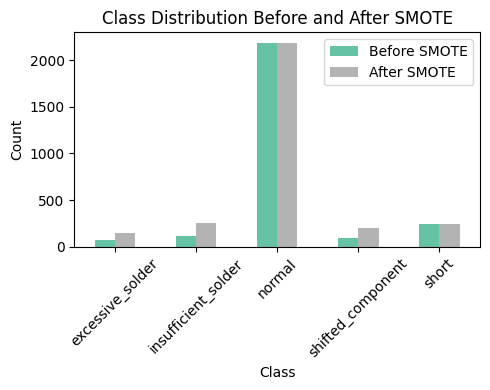

NameError: name 'y_proba' is not defined

In [ ]:
from sklearn.metrics import (
    roc_curve, auc, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight



# ----- Class Distribution Before and After SMOTE -----
def plot_class_distribution(y_before, y_after, class_mapping):
    labels = list(class_mapping.keys())
    before_counts = np.bincount(y_before)
    after_counts = np.bincount(y_after)

    df = pd.DataFrame({
        'Class': labels,
        'Before SMOTE': before_counts,
        'After SMOTE': after_counts
    })

    df.set_index('Class').plot(kind='bar', figsize=(5, 4), colormap='Set2')
    plt.title("Class Distribution Before and After SMOTE")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train, y_res, class_mapping)

# ----- ROC Curve for Multiclass -----
def plot_multiclass_roc(y_true, y_score, n_classes):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    plt.figure(figsize=(5, 5))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

plot_multiclass_roc(y_test, y_proba, n_classes=len(class_mapping))

######################################################################

# ---- Step 1: Train model on original (imbalanced) data ----
rf_before_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_before_smote.fit(X_train, y_train)
y_pred_before = rf_before_smote.predict(X_test)

# ---- Step 2: Train model on SMOTE-balanced data ----
rf_after_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_after_smote.fit(X_res, y_res)
y_pred_after = rf_after_smote.predict(X_test)

# ---- Step 3: False Positives per class ----
def count_false_positives_per_class(y_true, y_pred, class_mapping):
    false_positives = {label: 0 for label in class_mapping.values()}
    for pred, actual in zip(y_pred, y_true):
        if pred != actual:
            false_positives[pred] += 1
    return false_positives

fp_before = count_false_positives_per_class(y_test, y_pred_before, class_mapping)
fp_after = count_false_positives_per_class(y_test, y_pred_after, class_mapping)

# ---- Step 4: Visualization ----
def plot_fp_comparison_normal(fp_before, fp_after, class_mapping):
    # Get index of 'normal' class
    normal_index = class_mapping['normal']

    # Extract data for 'normal' class
    before_val = fp_before[normal_index]
    after_val = fp_after[normal_index]

    # Create DataFrame
    df = pd.DataFrame({
        'SMOTE': ['Before', 'After'],
        'False Positives': [before_val, after_val]
    })

    # Plot
    df.set_index('SMOTE').plot(kind='bar', figsize=(4, 3), colormap='Pastel1')
    plt.title("False Positives for 'normal' Class")
    plt.ylabel("Count")
    plt.xticks(rotation=0)  # No rotation for x-axis labels
    plt.tight_layout()



# ----- Print Class Info -----
classes = np.unique(y_train)
class_weight_dict = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train)))
print("Class Mapping:", class_mapping)
print("Predicted Probabilities:\n", y_proba)
print("Calculated class weights:", class_weight_dict)
print("Size of features:", X.size)

# ----- AUC-PR (Average Precision Score) -----
y_test_bin = label_binarize(y_test, classes=list(range(len(class_mapping))))
auc_pr = average_precision_score(y_test_bin, y_proba, average='weighted')
print(f"Weighted Average AUC-PR: {auc_pr:.2f}")



Accuracy: 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.57      0.67      0.62        30
           2       0.98      0.99      0.98       547
           3       0.71      0.43      0.54        23
           4       0.87      0.87      0.87        60

    accuracy                           0.94       678
   macro avg       0.79      0.75      0.76       678
weighted avg       0.94      0.94      0.94       678



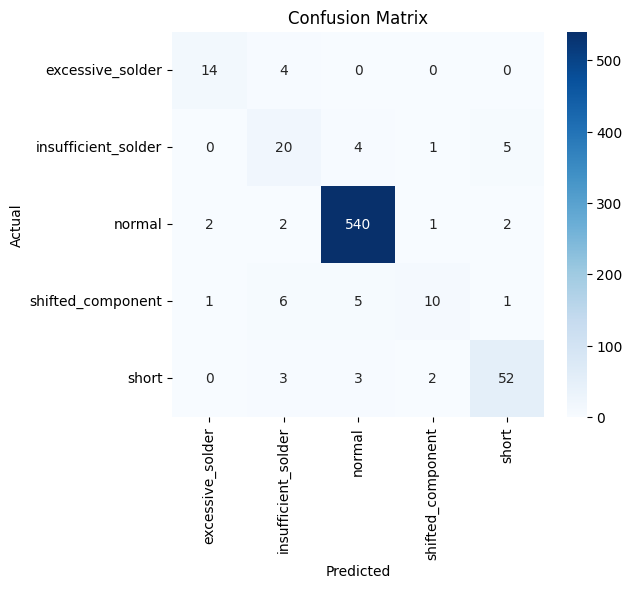

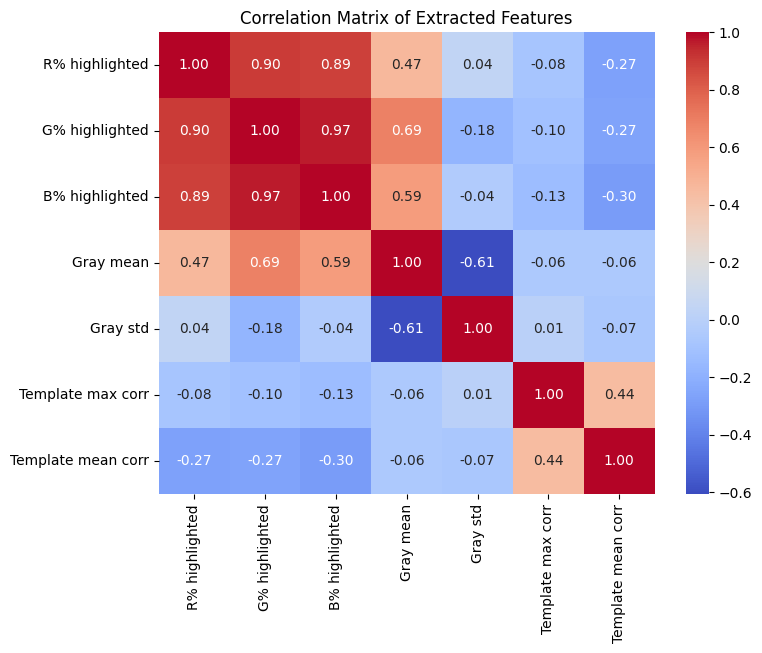

In [ ]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import match_template
from imblearn.over_sampling import SMOTE

# ------------------ Image pre processing ------------------

from skimage import exposure, filters
from skimage.restoration import denoise_bilateral
import numpy as np

def preprocess_image(image, img_size=(64, 64)):
    # Resize and scale to [0, 1]
    image = resize(image, img_size, anti_aliasing=True)

    # Convert grayscale to RGB
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[2] == 4:  # Remove alpha channel if present
        image = image[:, :, :3]

    # Optional: Apply histogram equalization (on each channel)
    for i in range(3):
        image[:, :, i] = exposure.equalize_adapthist(image[:, :, i])

    # Optional: Denoising
    #image = denoise_bilateral(image, multichannel=True)

    from skimage.restoration import denoise_bilateral
    image = denoise_bilateral(image, channel_axis=-1)  # -1 means last axis = color channels


    # Optional: Slight sharpening using unsharp mask (not too aggressive!)
    for i in range(3):
        image[:, :, i] = filters.unsharp_mask(image[:, :, i], radius=1, amount=1)

    return image

# ------------------ Custom Feature Extraction Functions ------------------


def highlighted_pixel_percentage(image, threshold=0.8):
    highlighted = (image > threshold).astype(int)
    total_pixels = image.shape[0] * image.shape[1]
    percentages = np.sum(highlighted, axis=(0, 1)) / total_pixels
    return percentages  # [R%, G%, B%]

def grey_values_of_highlighted(image, threshold=0.8):
    gray_img = rgb2gray(image)
    highlighted_mask = np.any(image > threshold, axis=2)
    highlighted_gray_values = gray_img[highlighted_mask]
    if highlighted_gray_values.size == 0:
        return [0, 0]
    return [np.mean(highlighted_gray_values), np.std(highlighted_gray_values)]

def template_matching_features(image, template):
    gray_img = rgb2gray(image)
    template_gray = rgb2gray(template)
    if template_gray.shape[0] > gray_img.shape[0] or template_gray.shape[1] > gray_img.shape[1]:
        return [0, 0]
    result = match_template(gray_img, template_gray)
    max_corr = np.max(result)
    mean_corr = np.mean(result)
    return [max_corr, mean_corr]

def extract_combined_features(image, template, threshold=0.8):
    hp_percent = highlighted_pixel_percentage(image, threshold)
    gray_stats = grey_values_of_highlighted(image, threshold)
    template_corr = template_matching_features(image, template)
    return np.concatenate([hp_percent, gray_stats, template_corr])  # Total 7 features

# ------------------ Image Loading and Feature Extraction ------------------

def load_images_with_features(dataset_path, img_size=(64, 64), threshold=0.8, template_img_path=None):
    labels = []
    features = []

    # Remove .ipynb_checkpoints folders
    for root, dirs, _ in os.walk(dataset_path):
        for d in dirs:
            if '.ipynb_checkpoints' in d:
                shutil.rmtree(os.path.join(root, d))

    class_names = sorted(os.listdir(dataset_path))
    class_mapping = {name: i for i, name in enumerate(class_names)}

    if template_img_path is None:
        raise ValueError("Template image path must be provided.")

    template = imread(template_img_path)
    template = resize(template, (32,32), anti_aliasing=True)

    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = imread(img_path)

                img_resized = preprocess_image(img, img_size)

                feats = extract_combined_features(img_resized, template, threshold)
                features.append(feats)
                labels.append(class_mapping[class_name])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return np.array(features), np.array(labels), class_mapping

# ------------------ Main Execution ------------------

# Define dataset path and parameters
DATASET_PATH = "/content/solder-joint-dataset-main"  # Adjust as needed
TEMPLATE_IMAGE_PATH = "/content/solder-joint-dataset-main/normal/normal_b1 (193).tiff"         # Provide your template path
IMG_SIZE = (64, 64)

# Load dataset
X, y, class_mapping = load_images_with_features(DATASET_PATH, IMG_SIZE, template_img_path=TEMPLATE_IMAGE_PATH)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE
sm = SMOTE(sampling_strategy={0: 150, 1: 250, 3: 200})
X_res, y_res = sm.fit_resample(X_train, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0:7.36,1:4.578,2:0.247,3:5.978,4:2.258666})
rf_model.fit(X_res,y_res)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="Blues", fmt="d",
            xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# --- Define your feature names (based on your 7 extracted features) ---
feature_names = [
    "R% highlighted", "G% highlighted", "B% highlighted",
    "Gray mean", "Gray std",
    "Template max corr", "Template mean corr"
]

feature_names = [
    "R% highlighted", "G% highlighted", "B% highlighted",
    "Gray mean", "Gray std",
    "Template max corr", "Template mean corr"
]
df = pd.DataFrame(X, columns=feature_names)

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))  # Adjust size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Extracted Features')
plt.show()

# --- Class label names from your class_mapping dictionary ---
class_names = list(class_mapping.keys())  # E.g., ['bridge', 'excessive_solder', ...]



